## **Notebook PC#03**
## Regularized ELM Classifier for the MNIST and CIFAR-10 database. Designed from scratch.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Gabriel Toffanetto França da Rocha - 289320 <br>
**Aluno(a):** Maria Fernanda Paulino Gomes - 206745 <br>


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from keras.datasets import mnist

(Xp, y), (Xtp, yt) = mnist.load_data()
Xa = Xp.reshape(Xp.shape[0], 784)
Xta = Xtp.reshape(Xtp.shape[0], 784)
X = Xa / 255.0
Xt = Xta / 255.0

print("Shape of X: ".ljust(10),  X.shape)
print("Shape of y: ".ljust(10),  y.shape)
print("Shape of Xt: ".ljust(10),  Xt.shape)
print("Shape of yt: ".ljust(10),  yt.shape)

11490434/11490434 [==============================] - 0s 0us/step
Shape of X:  (60000, 784)
Shape of y:  (60000,)
Shape of Xt:  (10000, 784)
Shape of yt:  (10000,)


In [ ]:
# Dataset balancing analysis
from tensorflow.keras.utils import to_categorical
import plotly.express as px

yy = to_categorical(y)
yyt = to_categorical(yt)
sum_along_columns1 = np.sum(yy, axis = 0)
print(sum_along_columns1)
sum_along_columns2 = np.sum(yyt, axis = 0)
print(sum_along_columns2)
fig1 = px.bar(x=range(10),y=sum_along_columns1, width=600, height=400,
              labels=dict(x="Class", y="Number of examples"), title="<b>Number of examples per class in the training dataset</b>")
fig1.update_layout(xaxis = dict(tickmode = 'linear', dtick = 1), title_x=0.5)
fig1.show()
fig2 = px.bar(x=range(10),y=sum_along_columns2, width=600, height=400,
              labels=dict(x="Class", y="Number of examples"), title="<b>Number of examples per class in the test dataset</b>")
fig2.update_layout(xaxis = dict(tickmode = 'linear', dtick = 1), title_x=0.5)
fig2.show()

[5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]
[ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]


In [ ]:
partition = 0.7

# Mixing the dataset before partitioning
index = np.arange(0,X.shape[0])
np.random.shuffle(index)

training_set_size = int(X.shape[0] * partition)

index_training = index[:training_set_size]
index_validation = index[training_set_size:]


X_training = X[index_training]
y_training = yy[index_training]

X_validation = X[index_validation]
y_validation = yy[index_validation]

# ELM X
# We will concatenate a column of 1's to account for the V0 of each hidden neuron later on
X_training_elm = np.concatenate((np.transpose(np.array([np.ones(X_training.shape[0])])), X_training), axis=1)
X_validation_elm = np.concatenate((np.transpose(np.array([np.ones(X_validation.shape[0])])), X_validation), axis=1)

print("X_training:".ljust(20), X_training.shape)
print("y_training:".ljust(20), y_training.shape)

print("X_validation:".ljust(20), X_validation.shape)
print("y_validation:".ljust(20), y_validation.shape)

print("X_training_elm:".ljust(20), X_training_elm.shape)
print("X_validation_elm:".ljust(20), X_validation_elm.shape)

X_training:          (42000, 784)
y_training:          (42000, 10)
X_validation:        (18000, 784)
y_validation:        (18000, 10)
X_training_elm:      (42000, 785)
X_validation_elm:    (18000, 785)


In [ ]:
def get_class_from_sample(sample: np.ndarray):
    class_ = 1
    for i in sample:
        if i == 0:
            class_ += 1
        else:
            break
    return class_

In [ ]:
def leaky_relu(table):
    return np.where(table > 0, table,  0.02 * table)

def relu(table):
    return np.where(table > 0, table,  0)

def get_h(X, V, activation_function):
    V_ = np.matmul(X, V)
    return activation_function(V_)

def get_w(X, y, c):
    w_1 = (np.matmul(np.transpose(X), X) + c * np.eye(X.shape[1]))
    w_2 = np.matmul(np.transpose(X), y)
    w,resid,rank,s = np.linalg.lstsq(w_1, w_2, rcond=None)
    return w

In [ ]:
def get_rates_from_c_values(X, y, c_values, Ws = []):
    hit_rates = []

    if len(Ws) != 0:
        are_Ws_given = True
    else:
        are_Ws_given = False
        Ws = []

    for index, c in enumerate(c_values):
        print(c)

        if are_Ws_given:
            W = Ws[index]
        else:
            W = get_w(X, y, c)
            Ws.append(W)

        y_estimate = np.matmul(X,W)
        hits = 0
        for index, estimate in enumerate(y_estimate):
            max_index = np.where(estimate == np.amax(estimate))[0][0]
            estimated_class = max_index + 1
            if estimated_class == get_class_from_sample(y[index]):
                hits += 1
        hit_rates.append(hits/y_estimate.shape[0])
    return hit_rates, Ws

In [ ]:
# Standard deviation of the random weight generation at the hidden layer
sigma = 0.2
# Number of inputs for the MNIST dataset: 785
# Take 1000 hidden neurons for the MNIST dataset
V  = sigma * np.random.randn(785, 1000)

In [ ]:
c_values = [pow(2,d) for d in range(-16, 15, 2)] # Range goes up to 15 to ensure search up to 2^14

hit_rates_training, Ws = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, c_values)

1.52587890625e-05
6.103515625e-05
0.000244140625
0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384


In [ ]:
hit_rates_validation, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, c_values, Ws)

1.52587890625e-05
6.103515625e-05
0.000244140625
0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384


Best c value: 256 
Performance of this value: 0.9404444444444444


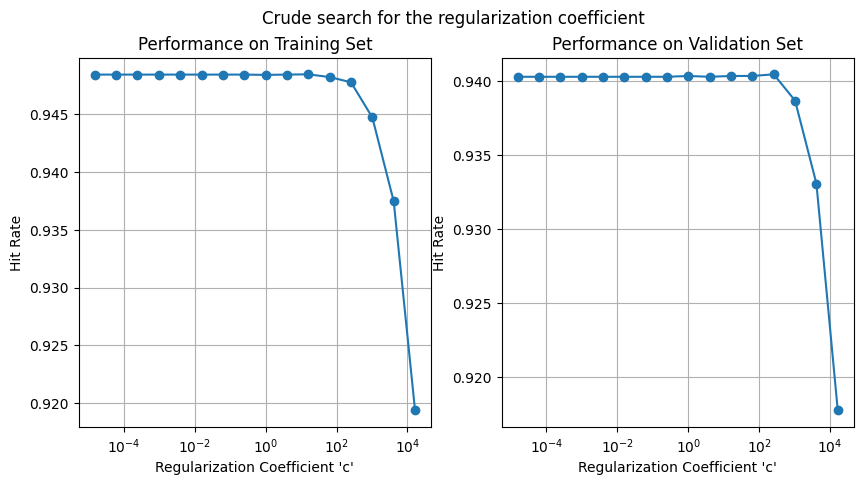

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training Set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation Set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation[best_c_index]))


**Nota**: Ao analisar o gráfico da direita acima, só corrija o intervalo de busca caso não haja uma queda de desempenho para valores elevados do coeficiente de regularização. Caso o melhor coeficiente de regularização seja o de menor valor, siga adiante, pois isso indica a ausência de necessidade de regularizar esta solução.

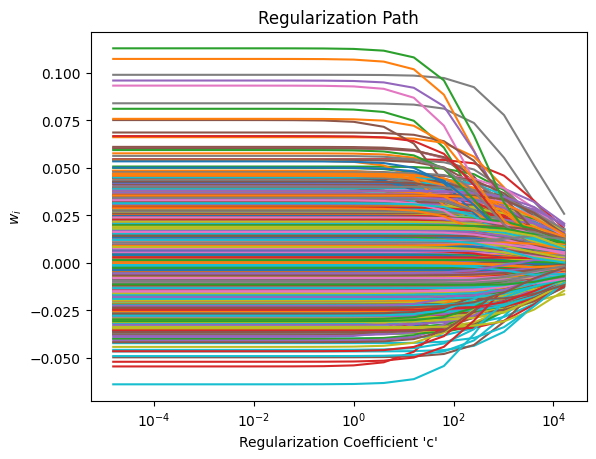

In [ ]:
lambd_values = c_values
w_values = Ws

def plot_regularization_path(lambd_values, w_values):
    num_coeffs = len(w_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in w_values])
    plt.xlabel(r"Regularization Coefficient 'c'", fontsize=10)
    plt.ylabel(r"$w_i$", fontsize=10)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()

plot_regularization_path(lambd_values, w_values)

<font color="green">
Atividade (a) <br>
Explique o comportamento das curvas [Regularization Path] e [Performance on Validation Set] logo acima, vinculando os seus comportamentos. <br>
</font>

Resposta: Ao analisar as curvas do gráfico 'Regularization Path', é possível inferir que a medida quem que a regularização do coeficiente 'c' vai aumentando, os pesos tendem a zero. Vinculando ao comportamento do gráfico 'Performance on Validation Set', é possível analisar que a taxa de acerto atinge o pico, ou seja, a taxa de acerto máximo próximo a uma regularização do coeficiente 'c' de 10^2, após esse valor de regularização, a taxa de acerto começa a cair, isso ocorre, porque após esse valor, os pesos tendem a zero, com os pesos tendendo a zero, a taxa de acerto também tende a zero, visto que o segredo para uma boa taxa de acerto está na boa regularização dos pesos sinápticos.

In [ ]:
step =  0.1 * (4 * best_c - best_c / 4);

fine_c_values = np.arange((best_c/4), (4*best_c) + step / 10, step)

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, fine_c_values)

64.0
160.0
256.0
352.0
448.0
544.0
640.0
736.0
832.0
928.0
1024.0


In [ ]:
hit_rates_validation_fine, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, fine_c_values, Ws_fine)

64.0
160.0
256.0
352.0
448.0
544.0
640.0
736.0
832.0
928.0
1024.0


Best c value: 256.0 
Performance of this value: 0.9404444444444444


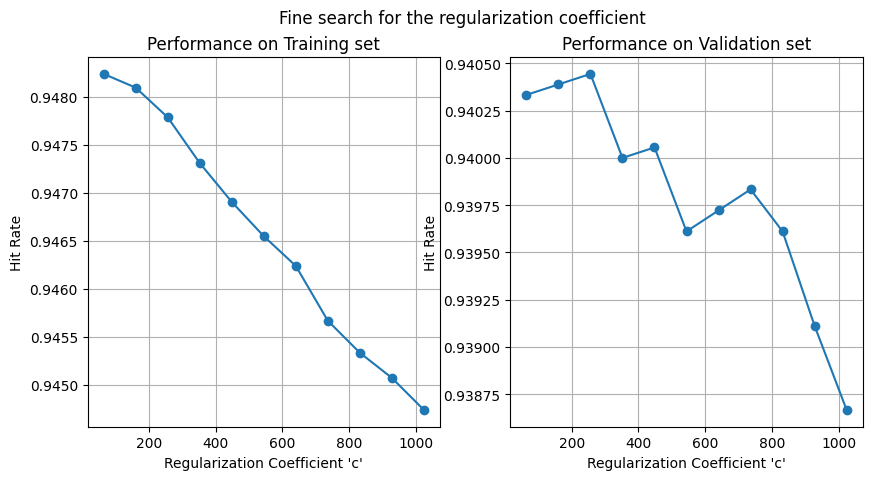

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [ ]:
X_elm = np.concatenate((np.transpose(np.array([np.ones(X.shape[0])])), X), axis=1)
W_elm = get_w(get_h(X_elm, V, relu), yy, best_c)

In [ ]:
Xt_elm = np.concatenate((np.transpose(np.array([np.ones(Xt.shape[0])])), Xt), axis=1)
yt_estimate = np.matmul(get_h(Xt_elm, V, relu),W_elm)
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
confusion_matrix_df

Performance on test set: 0.9434


,0,1,2,3,4,5,6,7,8,9
0,965,0,8,2,1,10,9,1,8,4
1,0,1124,2,1,5,1,3,16,4,5
2,0,2,953,10,4,3,3,21,6,4
3,1,2,11,932,0,13,0,4,9,9
4,0,1,5,0,918,7,9,5,7,19
5,3,0,2,30,0,828,8,0,13,8
6,6,4,7,1,13,10,919,0,14,2
7,2,0,11,12,1,4,2,959,6,10
8,3,2,29,14,7,11,4,1,898,10
9,0,0,4,8,33,5,1,21,9,938


<font color="green">
Atividade (b) <br>
O que sustenta o ganho de desempenho na taxa de acerto de classificação quando comparado ao classificador linear do PC01? Repare que a estratégia de otimização é a mesma nos dois casos. <br>
</font>

Resposta: A otimização em ambos os casos foi feita utilizando uma busca mais refinada nos valores de regularização do parâmetro 'c', sendo essa busca feita em torno do melhor valor de 'c' encontrado anteriormente ('best_c). Mesmo utilizando a mesma estratégia de otimização, no PC01 o desempenho na taxa de acerto foi de 0.8564, já agora foi de 0.9393. Esse aumento de desempenho pode ser atribuído ao uso de ELM ao invés do classificador linear, uma vez que a ELM possui uma maior capacidade de representação não linear, visto que possui uma camada oculta com neurônios de pesos fixos que possuem função de ativação não linear. Nesse caso, foi utilizada a função ReLU, o que permite a captura de padrões que um classificador linear não seria capaz de aprender.

Image no. 8


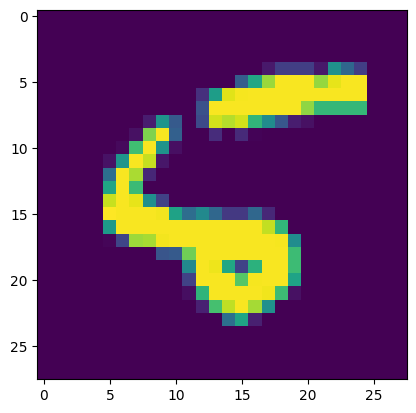

Real: 5
Predicted: 4
Rank of the correct answer: 3
Probabilities: [-0.00661698 -0.10884486  0.15717337 -0.03465637  0.43727309  0.25113594
  0.28527554 -0.04202695  0.00449918  0.15020587] 

Image no. 54


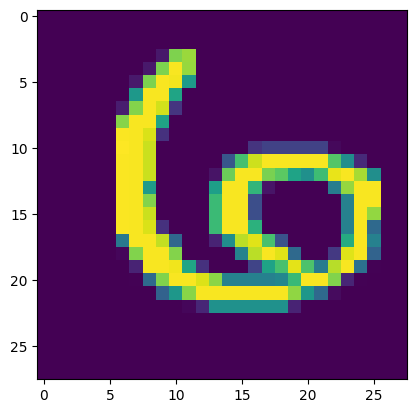

Real: 6
Predicted: 2
Rank of the correct answer: 2
Probabilities: [ 0.10803316 -0.05954008  0.49955791 -0.08832916 -0.04020614 -0.08461713
  0.48423577 -0.06361216  0.18615366  0.11084832] 

Image no. 80


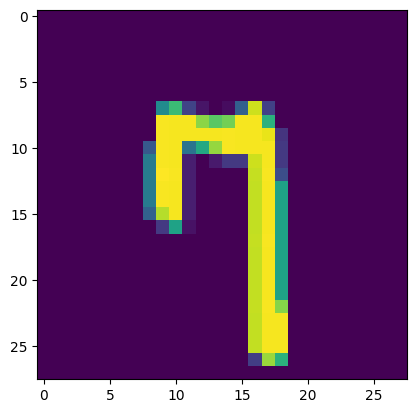

Real: 7
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.08317139  0.07091348 -0.08030694 -0.13294023  0.16905339  0.05856918
 -0.06038942  0.47088319 -0.08021232  0.47294853] 

Image no. 115


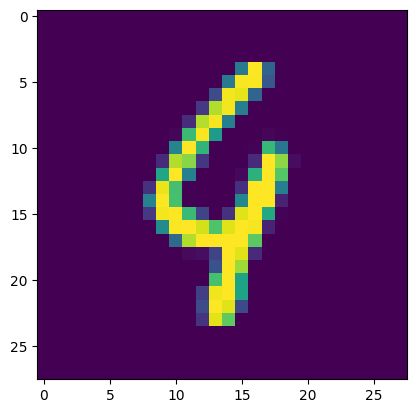

Real: 4
Predicted: 9
Rank of the correct answer: 2
Probabilities: [-0.02492975  0.14397094  0.06397438 -0.06873794  0.34267847 -0.01940007
  0.16633886 -0.04004055  0.0102574   0.47006628] 

Image no. 149


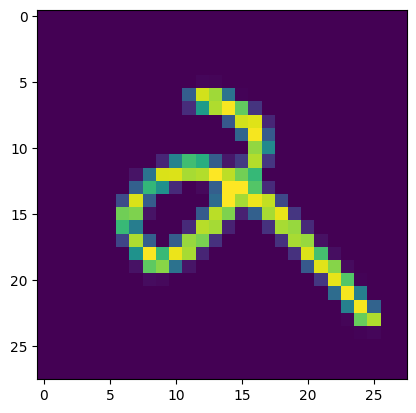

Real: 2
Predicted: 9
Rank of the correct answer: 3
Probabilities: [-0.04430756  0.13423217  0.2402165   0.30426885  0.1632901  -0.07782934
 -0.10436421 -0.04498152  0.08876858  0.3508804 ] 

Image no. 193


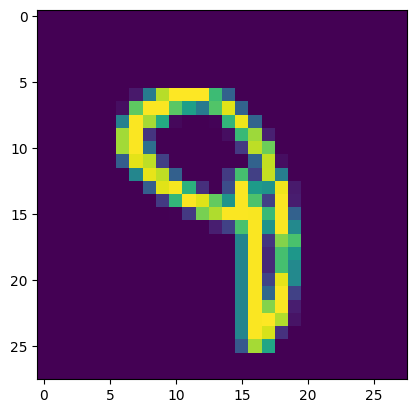

Real: 9
Predicted: 3
Rank of the correct answer: 2
Probabilities: [-0.00076888 -0.12871027  0.0126503   0.33803232  0.14233537  0.01548755
 -0.01136478  0.10250891  0.06962895  0.33164395] 

Image no. 195


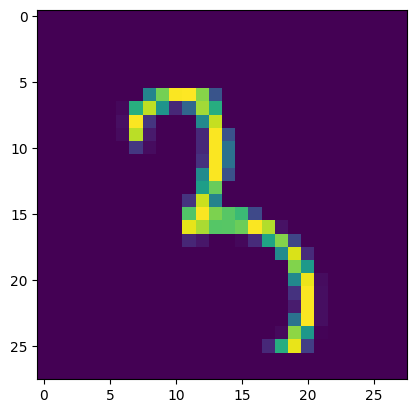

Real: 3
Predicted: 8
Rank of the correct answer: 6
Probabilities: [-0.06425761  0.082738    0.12498503  0.10301101 -0.05252276  0.1044471
  0.10317759  0.19066975  0.22037422  0.05202032] 



In [ ]:
# Devoted solely to the MNIST dataset
def find_pos(item, lst):
    pos = [i for (z, i) in zip(lst, range(len(lst))) if item == z]
    return pos

def display_sample(sample: np.ndarray):

    sample = np.array(sample, dtype='float')
    pixels = np.zeros((28,28))

    for i in range(28):
        for j in range(28):
            pixels[i,j] = sample[i * 28 + j]

    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='viridis')
    plt.show()

yt_estimate = np.matmul(get_h(Xt_elm, V, relu),W_elm)
for i in range(200):
    if yyt[i][np.argmax(yt_estimate[i,:])] != 1:
      print(f"Image no. {i}")
      display_sample(Xt[i])
      print(f"Real: {np.argmax(yyt[i,:])}")
      print(f"Predicted: {np.argmax(yt_estimate[i,:])}")
      value = yt_estimate[i,np.argmax(yyt[i,:])]
      v_sorted = np.sort(yt_estimate[i,:])
      value_index = find_pos(value,v_sorted)
      print(f"Rank of the correct answer: {10 - value_index[0]}")
      print(f"Probabilities: {yt_estimate[i,:]} \n")

##Repetindo os principais passos, agora para a base CIFAR-10.

In [ ]:
from keras.datasets import cifar10

(Xp, y), (Xtp, yt) = cifar10.load_data()
Xa = Xp.reshape(Xp.shape[0], 3072)
Xta = Xtp.reshape(Xtp.shape[0], 3072)
y = y.ravel()
yt = yt.ravel()
X = Xa / 255.0
Xt = Xta / 255.0

print("Shape of X: ".ljust(10),  X.shape)
print("Shape of y: ".ljust(10),  y.shape)
print("Shape of Xt: ".ljust(10),  Xt.shape)
print("Shape of yt: ".ljust(10),  yt.shape)

yy = to_categorical(y)
yyt = to_categorical(yt)

170498071/170498071 [==============================] - 2s 0us/step
Shape of X:  (50000, 3072)
Shape of y:  (50000,)
Shape of Xt:  (10000, 3072)
Shape of yt:  (10000,)


In [ ]:
partition = 0.7

# Mixing the dataset before partitioning
index = np.arange(0,X.shape[0])
np.random.shuffle(index)

training_set_size = int(X.shape[0] * partition)

index_training = index[:training_set_size]
index_validation = index[training_set_size:]


X_training = X[index_training]
y_training = yy[index_training]

X_validation = X[index_validation]
y_validation = yy[index_validation]

# ELM X
# We will concatenate a column of 1's to account for the V0 of each hidden neuron later on
X_training_elm = np.concatenate((np.transpose(np.array([np.ones(X_training.shape[0])])), X_training), axis=1)
X_validation_elm = np.concatenate((np.transpose(np.array([np.ones(X_validation.shape[0])])), X_validation), axis=1)

print("X_training:".ljust(20), X_training.shape)
print("y_training:".ljust(20), y_training.shape)

print("X_validation:".ljust(20), X_validation.shape)
print("y_validation:".ljust(20), y_validation.shape)

print("X_training_elm:".ljust(20), X_training_elm.shape)
print("X_validation_elm:".ljust(20), X_validation_elm.shape)

X_training:          (35000, 3072)
y_training:          (35000, 10)
X_validation:        (15000, 3072)
y_validation:        (15000, 10)
X_training_elm:      (35000, 3073)
X_validation_elm:    (15000, 3073)


In [ ]:
# Standard deviation of the random weight generation at the hidden layer
sigma = 0.2
# Number of inputs for the CIFAR10 dataset: 3073
# Take 2000 hidden neurons for the CIFAR10 dataset.
V  = sigma * np.random.randn(3073, 2000)

In [ ]:
c_values = [pow(2,d) for d in range(-8, 21, 2)] # Range goes up to 21 to ensure search up to 2^20

hit_rates_training, Ws = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, c_values)

0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536
262144
1048576


In [ ]:
hit_rates_validation, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, c_values, Ws)

0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536
262144
1048576


Best c value: 4096 
Performance of this value: 0.46153333333333335


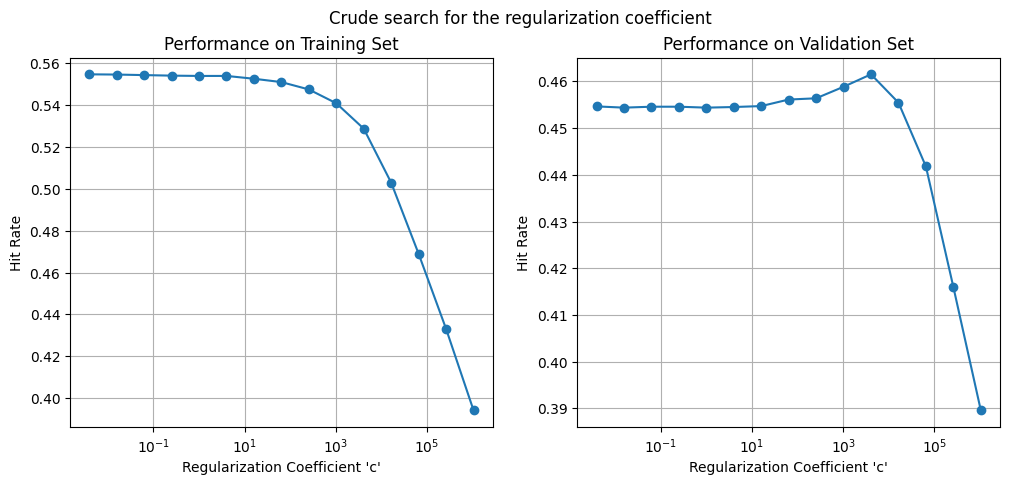

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training Set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation Set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation[best_c_index]))


**Nota**: Ao analisar o gráfico da direita acima, só corrija o intervalo de busca caso não haja uma queda de desempenho para valores elevados do coeficiente de regularização. Caso o melhor coeficiente de regularização seja o de menor valor, siga adiante, pois isso indica a ausência de necessidade de regularizar esta solução.

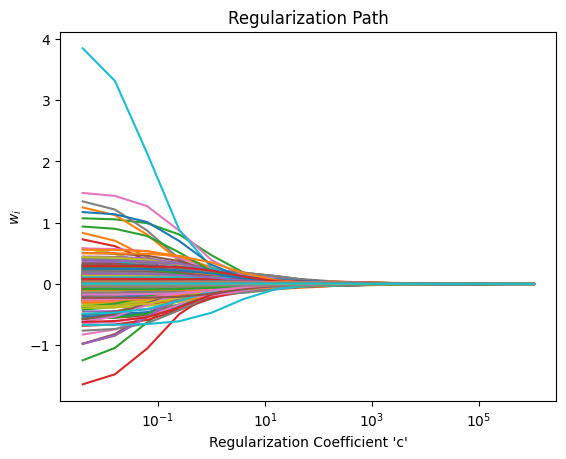

In [ ]:
lambd_values = c_values
w_values = Ws

def plot_regularization_path(lambd_values, w_values):
    num_coeffs = len(w_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in w_values])
    plt.xlabel(r"Regularization Coefficient 'c'", fontsize=10)
    plt.ylabel(r"$w_i$", fontsize=10)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()

plot_regularization_path(lambd_values, w_values)

In [ ]:
step =  0.1 * (4 * best_c - best_c / 4);

fine_c_values = np.arange((best_c/4), (4*best_c) + step / 10, step)

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, fine_c_values)

1024.0
2560.0
4096.0
5632.0
7168.0
8704.0
10240.0
11776.0
13312.0
14848.0
16384.0


In [ ]:
hit_rates_validation_fine, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, fine_c_values, Ws_fine)

1024.0
2560.0
4096.0
5632.0
7168.0
8704.0
10240.0
11776.0
13312.0
14848.0
16384.0


Best c value: 5632.0 
Performance of this value: 0.4619333333333333


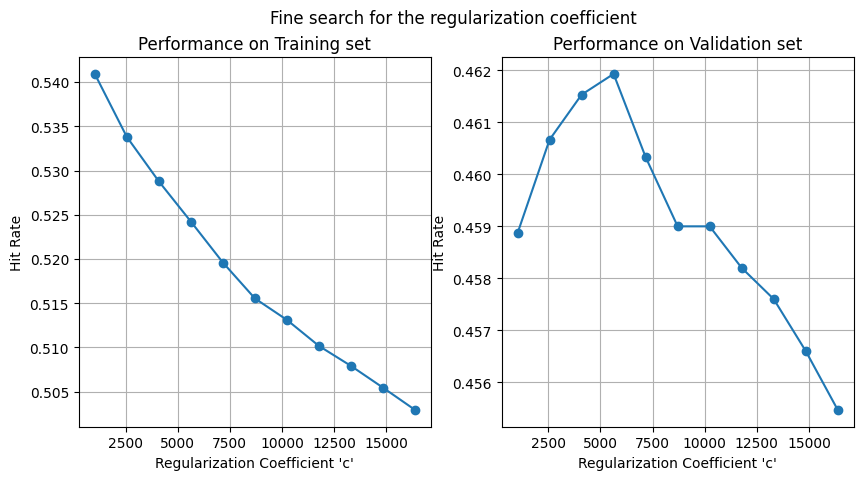

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [ ]:
X_elm = np.concatenate((np.transpose(np.array([np.ones(X.shape[0])])), X), axis=1)
W_elm = get_w(get_h(X_elm, V, relu), yy, best_c)

In [ ]:
Xt_elm = np.concatenate((np.transpose(np.array([np.ones(Xt.shape[0])])), Xt), axis=1)
yt_estimate = np.matmul(get_h(Xt_elm, V, relu),W_elm)
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
confusion_matrix_df

Performance on test set: 0.4669


,0,1,2,3,4,5,6,7,8,9
0,529,39,111,57,70,32,19,39,102,41
1,48,583,43,54,30,40,34,43,77,190
2,45,8,290,63,111,78,59,49,9,12
3,12,21,71,244,44,140,50,43,18,25
4,16,9,106,52,364,62,92,72,14,5
5,19,21,67,186,51,371,59,63,31,18
6,27,31,144,157,155,99,593,43,10,37
7,41,37,88,62,116,93,44,528,20,49
8,199,80,47,47,39,48,23,41,640,96
9,64,171,33,78,20,37,27,79,79,527


<font color="green">
Atividade (c) <br>
No link a seguir, afirma-se que uma das vantagens das ELMs é que elas [can learn from the training data in one step, without repeating the learning process in multiple steps.] Não foi o que fizemos neste PC03. Qual é o risco de treinar uma ELM em apenas um passo? <br>
</font>

[Extreme Learning Machine - Advantage of ELM](https://www.geeksforgeeks.org/extreme-learning-machine/)

Resposta: Embora as ELMs possam ser treinadas em um único passo, neste PC03, não foi utilizada essa técnica, a ELM foi treinada em mais de um passo, o que pode ser inferrindo pelo uso da otimização em busca do melhor valor do coeficiente de regularização 'c' e pela análise da performance nos conjuntos de treinamento e de validação, indicando que fou utilizado um processo iterativo de treinamento e ajuste do modelo. Os riscos de treinar uma ELM em um único passo estão associados ao risco de overfitting, uma vez que com o treinamento em um único passo a ELM pode não ficar regularizada de forma adequada, possuindo baixa capacidade de generalização, uma vez que não teria a capacidade de adaptar os hiperparâmetros (como foi feito para o coeficiente de regularização 'c'), gerando resultados insatisfatórios.

<font color="green">
Atividade (d) <br>
Uma vez treinada uma ELM, que estratégia você adotaria para eliminar neurônios da camada intermediária, caso uma implementação prática indicasse uma limitação de memória? A sua resposta deve propor uma subrede ELM extraída da rede ELM completa já treinada, capaz de exibir máximo desempenho de generalização. Considere que o número de neurônios que precisam ser eliminados é uma porcentagem arbitrária do número total. Considere também que a sua estratégia não deve se basear na amplitude dos pesos individuais da camada de saída (essa seria uma estratégia possível, mas não deve ser adotada aqui). <br>
</font>

Resposta: Tendo treinado a rede, uma maneira de se obter o modelo reduzido, diminuindo os neurônios da camada intermediária é analisando a matriz H, que é a matriz utilizada para encontrar os pesos sinápticos, nessa matriz encontram-se as ativações de todos os neurônios para todos os padrões de entrada. Nessa matriz, cada coluna representa um neurônio, dessa forma, uma estratégia a ser considerada para reduzir o número de neurônios da camada intermediária é eliminar as colunas da matriz H que apresentem a menor norma, visto nessas situações, a influência dessas colunas (neurônios) é mínima no desempenho da rede, podendo então retirar essas colunas da matriz H e consequentemente reduzir o número de neurônios da camada intermediária. Essa seria uma maneira de solucionar o problema de limitação de memória, eliminando neurônios da camada intermediária que apresentam menos contribuíção na saída da rede devido à norma do seu vetor de pesos v.
